<a href="https://colab.research.google.com/github/ADHIL-VENGAT/CE888-DataScience-and-Decision-making/blob/main/causal_inference_CE888_lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEP 1 Packages**

In [3]:
!pip install econml

In [2]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**STEP 2.2 METRICS**

In [4]:
def abs_ate(effect_true, effect_pred):
    """
    Absolute error for the Average Treatment Effect (ATE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: absolute error on ATE
    """
    # YOUR CODE HERE
    return abs(sum(effect_true)/len(effect_true) - sum(effect_pred)/len(effect_pred))

def pehe(effect_true, effect_pred):
    """
    Precision in Estimating the Heterogeneous Treatment Effect (PEHE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: PEHE
    """
    # YOUR CODE HERE
    return np.sqrt(np.mean((effect_true - effect_pred)**2))

**Step 2.3 - data**

In [5]:
!wget https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz

--2022-02-09 13:43:56--  https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz [following]
--2022-02-09 13:43:57--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320962 (313K) [application/octet-stream]
Saving to: ‘sodium_10k.npz’

sodium_10k.npz      100%[===================>] 313.44K  --.-KB/s    in 0.03s   

2022-02-09 13:43:57 (9.49 MB/s) - ‘sodium_10k.npz’ saved [320962/320962]



In [6]:
data = np.load('sodium_10k.npz')

In [9]:
data.files

['x', 't', 'y', 'ite']

In [11]:
for f in data.files:
  print(f'{f}: {data[f].shape}')

x: (10000,)
t: (10000,)
y: (10000,)
ite: (10000,)


In [12]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
ite = data['ite']

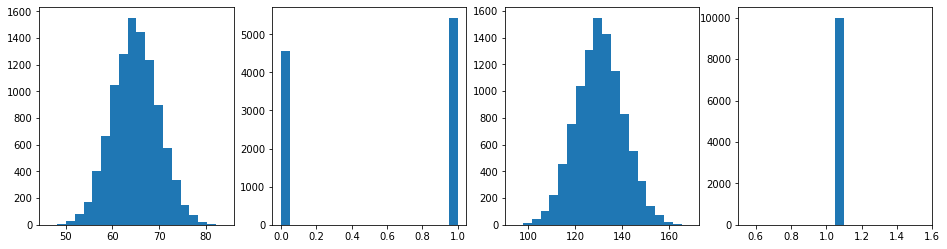

In [14]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

In [15]:
np.mean(ite)

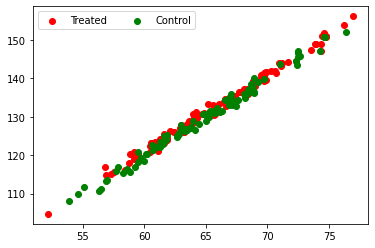

In [20]:
limit = 100
plt.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
plt.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

**Step 2.4 - data pre-processing**

In [21]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

**Step 2.5 - training**

In [24]:
# Random Forest with default parameters.
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
# Hint: use np.concatenate or np.hstack functions to merge X and T.

xt_train = np.concatenate([x_train, t_train], axis=1) # YOUR CODE HERE
rf.fit(xt_train, y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Predict Y_0 given [X, 0]
# Hint: use np.zeros_like or np.zeros functions to get the zeros for all units.
# Hint 2: you still have to merge X and zeros (see training above).
xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1)# YOUR CODE HERE
rf_y0_test = rf.predict(xt0_test)

# Predict Y_1 given [X, 1]
# Hint: use np.ones_like or np.ones functions to get the ones for all units.
# Hint 2: you still have to merge X and ones (see training above).
xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1) # YOUR CODE HERE
rf_y1_test = rf.predict(xt1_test)

# Compute ITEs
# ITE = Y_1 - Y_0
rf_te_test = rf_y1_test - rf_y0_test # YOUR CODE HERE

In [25]:
rf_te_test

array([0.24963628, 1.24630509, 0.51863301, ..., 1.60233355, 1.28706001,
       1.36121486])

**Random Forest with IPW**

In [26]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi =  ti/(ptx)  +  (1 - ti)/(1 - (ptx))   # YOUR CODE HERE
  return wi

In [27]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight= weights )

# Make predictions
rf_ipsw_y0_test = rf_ipsw.predict(xt0_test) # YOUR CODE HERE
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test)# YOUR CODE HERE

# Compute ITEs
rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test # YOUR CODE HERE

In [28]:
rf_ipsw_te_test

array([0.0707231 , 1.5156305 , 0.24736816, ..., 0.97504311, 1.09548338,
       1.51685178])

**X-learner**

In [29]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_test = xl.effect(x_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
